* **This is a WIP colab**.
* TODO:
  - Cleanup

We recommend that you run this notebook with TPU runtimes. This would make it much easier for you to work with the BERT models.

# Some initial setup.

Feel free to skip.

In [9]:
!mkdir fonts/

# Download the fonts we need.
!wget -qO Noto_Sans.zip https://drive.google.com/uc?id=1-0tqK8qCFRVqsRZag4YYJmy2ZnPOD5VD&export=download 
!unzip -qo Noto_Sans.zip -d fonts/Noto_Sans
!wget -qO Roboto.zip https://drive.google.com/uc?id=1Xo2EUtHc5CIAo3l5V1FbtRopbV7_u-Cu&export=download
!unzip -qo Roboto.zip -d fonts/Roboto
!wget -qO Poppins.zip https://drive.google.com/uc?id=18Flk0fW_8RBNmKyDJEnMA43GjFjxp-i0&export=download
!unzip -qo Poppins.zip -d fonts/Poppins

!rm Noto_Sans.zip Roboto.zip Poppins.zip

!pip install -q git+https://github.com/EfficientDL/codelab_utils.git

import matplotlib.pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Noto Sans'

mkdir: cannot create directory ‘fonts/’: File exists


# Initializing the TPU

In [2]:
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='')
tpu_strategy = tf.distribute.TPUStrategy(resolver)

# Creating the dataset.

One common thing that might trip you when using TPUs is the use of the local filesystem. For now, it seems that TPUs within Google Colab cannot directly access the local filesystem, and it is recommended that we use GCS buckets instead. A workaround here is to explicitly let Tensorflow know that our dataset will be on the same machine. This might change in the future.

In [4]:
import tensorflow_datasets as tfds
with tf.device('/job:localhost'):
  ds = tfds.load('ag_news_subset', try_gcs=True, shuffle_files=True, 
                 batch_size=-1)
  
train_dataset = tf.data.Dataset.from_tensor_slices(ds['train'])
test_dataset = tf.data.Dataset.from_tensor_slices(ds['test'])

BATCH_SIZE = 256
batched_train = train_dataset.shuffle(train_dataset.cardinality()).batch(BATCH_SIZE)
batched_test = test_dataset.shuffle(test_dataset.cardinality()).batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ag_news_subset/1.0.0.incompleteUQVOL7/ag_news_subset-train.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ag_news_subset/1.0.0.incompleteUQVOL7/ag_news_subset-test.tfrecord*...:   0%| …

Dataset ag_news_subset downloaded and prepared to ~/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [3]:
!pip install -q "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [8]:
import os
import tensorflow_hub as hub

# tensorflow_text is required so that we can use certain ops used in the TF Hub
# model. 
import tensorflow_text as tf_text

# This line is required, once again, so that the TPU doesn't complain about the
# weights of the TF Hub models being on local storage.
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'UNCOMPRESSED'

# Check out the TF hub website for more preprocessors
preprocessor = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

# Enable the next line to check out preprocessor output
# preprocessor(tf.constant(['hello world']))

In [14]:
# Create the final datasets that the BERT model will work on.
train_ds = batched_train.map(
    lambda x: (preprocessor(x['description']), 
               tf.expand_dims(x['label'], axis=-1)))

test_ds = batched_test.map(
    lambda x: (preprocessor(x['description']), 
               tf.expand_dims(x['label'], axis=-1)))

# Creating the model.

In [12]:
BERT_ENCODERS = {
    # Recommended, because it is fast and has same interface as base BERT
    'bert-small': "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
    'bert-base': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
}

In [10]:
import numpy as np

def shuffle_weights(model, weights=None):
  """Shuffle the weights in the given model.
  
  This is a fast approximation of re-initializing the model weights.
  """
  if weights is None:
      weights = model.get_weights()
  weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
  model.set_weights(weights)

def get_bert_model(
    encoder_size,
    learning_rate=2e-5, 
    keep_tfhub_weights=True,
    num_classes=4):
  """Create a BERT classifier."""
  with tpu_strategy.scope():
    # Prepare the inputs.
    bert_inputs = dict(
        input_word_ids=tf.keras.layers.Input(
            shape=(None,), dtype=tf.int32, name='input_word_ids'),
        input_mask=tf.keras.layers.Input(
            shape=(None,), dtype=tf.int32, name='input_mask'),
        input_type_ids=tf.keras.layers.Input(
            shape=(None,), dtype=tf.int32, name='input_type_ids'),
    )
    
    # Create the encoder layer from TF Hub.
    bert_encoder = hub.KerasLayer(
        BERT_ENCODERS.get(encoder_size, 'bert-small'),
        trainable=True,
        name='bert_encoder')
    
    # Collect the output.
    output = bert_encoder(bert_inputs)['pooled_output']
    
    # Add a few dense layers + non-linearities in the end.
    output = tf.keras.layers.Dense(200, activation='relu')(output)
    output = tf.keras.layers.Dense(100, activation='relu')(output)
    output = tf.keras.layers.Dense(50, activation='relu')(output)
    output = tf.keras.layers.Dense(num_classes, activation=None)(output)
    output = tf.keras.layers.Activation('softmax')(output)
    bert_classifier = tf.keras.Model(bert_inputs, output)
    
    bert_classifier.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    if not keep_tfhub_weights:  
      shuffle_weights(bert_classifier)
  
  return bert_classifier

In [56]:
def plot_training_trajectories(histories, titles):
  """Helper method for plotting training trajectories."""
  fig = plt.figure()
  fig.patch.set_facecolor('white')

  markers = ['-o', '-^']

  for idx, (history, title) in enumerate(zip(histories, titles)):
    accuracy_history = history.history['val_accuracy']
    max_acc = np.max(accuracy_history) * 100
    epochs = [x for x in range(1, len(accuracy_history) + 1)]
    plt.xticks(epochs)
    plt.plot(
        epochs, accuracy_history, markers[idx],
        label = f'{title} (val). Best Accuracy: {max_acc:.2f}%',
    )

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend(loc='lower right')
  plt.show()

# Model Training

In this section we will train BERT models of different sizes, with and without pre-training weights. We have done some lightweight hyper-parameter tuning of the learning rate to try to find the best possible performance for both the scenarios (pre-training / training from scratch).

## Smaller BERT models.

In [35]:
bert_small_from_scratch_classifier = get_bert_model(
    'bert-small', learning_rate=1e-4, keep_tfhub_weights=False)
bert_small_from_scratch_classifier_history = bert_small_from_scratch_classifier.fit(
    x=train_ds, epochs=4, validation_data=test_ds)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/PartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("Adam/gradients/PartitionedCall:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("Adam/gradients/PartitionedCall:2", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


469/469 [==============================] - 51s 59ms/step - loss: 0.7432 - accuracy: 0.6898 - val_loss: 0.3910 - val_accuracy: 0.8642
Epoch 2/4
469/469 [==============================] - 16s 33ms/step - loss: 0.3552 - accuracy: 0.8770 - val_loss: 0.3252 - val_accuracy: 0.8879
Epoch 3/4
469/469 [==============================] - 16s 34ms/step - loss: 0.2856 - accuracy: 0.9022 - val_loss: 0.2925 - val_accuracy: 0.9000
Epoch 4/4
469/469 [==============================] - 16s 33ms/step - loss: 0.2481 - accuracy: 0.9151 - val_loss: 0.2870 - val_accuracy: 0.9033


In [18]:
bert_small_pretrained_classifier = get_bert_model(
    'bert-small', learning_rate=8e-5, keep_tfhub_weights=True)
bert_small_pretrained_classifier_history = bert_small_pretrained_classifier.fit(
    x=train_ds, epochs=4, validation_data=test_ds)

Epoch 1/4
469/469 [==============================] - 41s 54ms/step - loss: 0.4249 - accuracy: 0.8590 - val_loss: 0.2892 - val_accuracy: 0.9021
Epoch 2/4
469/469 [==============================] - 16s 34ms/step - loss: 0.2663 - accuracy: 0.9088 - val_loss: 0.2616 - val_accuracy: 0.9079
Epoch 3/4
469/469 [==============================] - 16s 33ms/step - loss: 0.2256 - accuracy: 0.9217 - val_loss: 0.2522 - val_accuracy: 0.9134
Epoch 4/4
469/469 [==============================] - 16s 34ms/step - loss: 0.1943 - accuracy: 0.9324 - val_loss: 0.2477 - val_accuracy: 0.9159


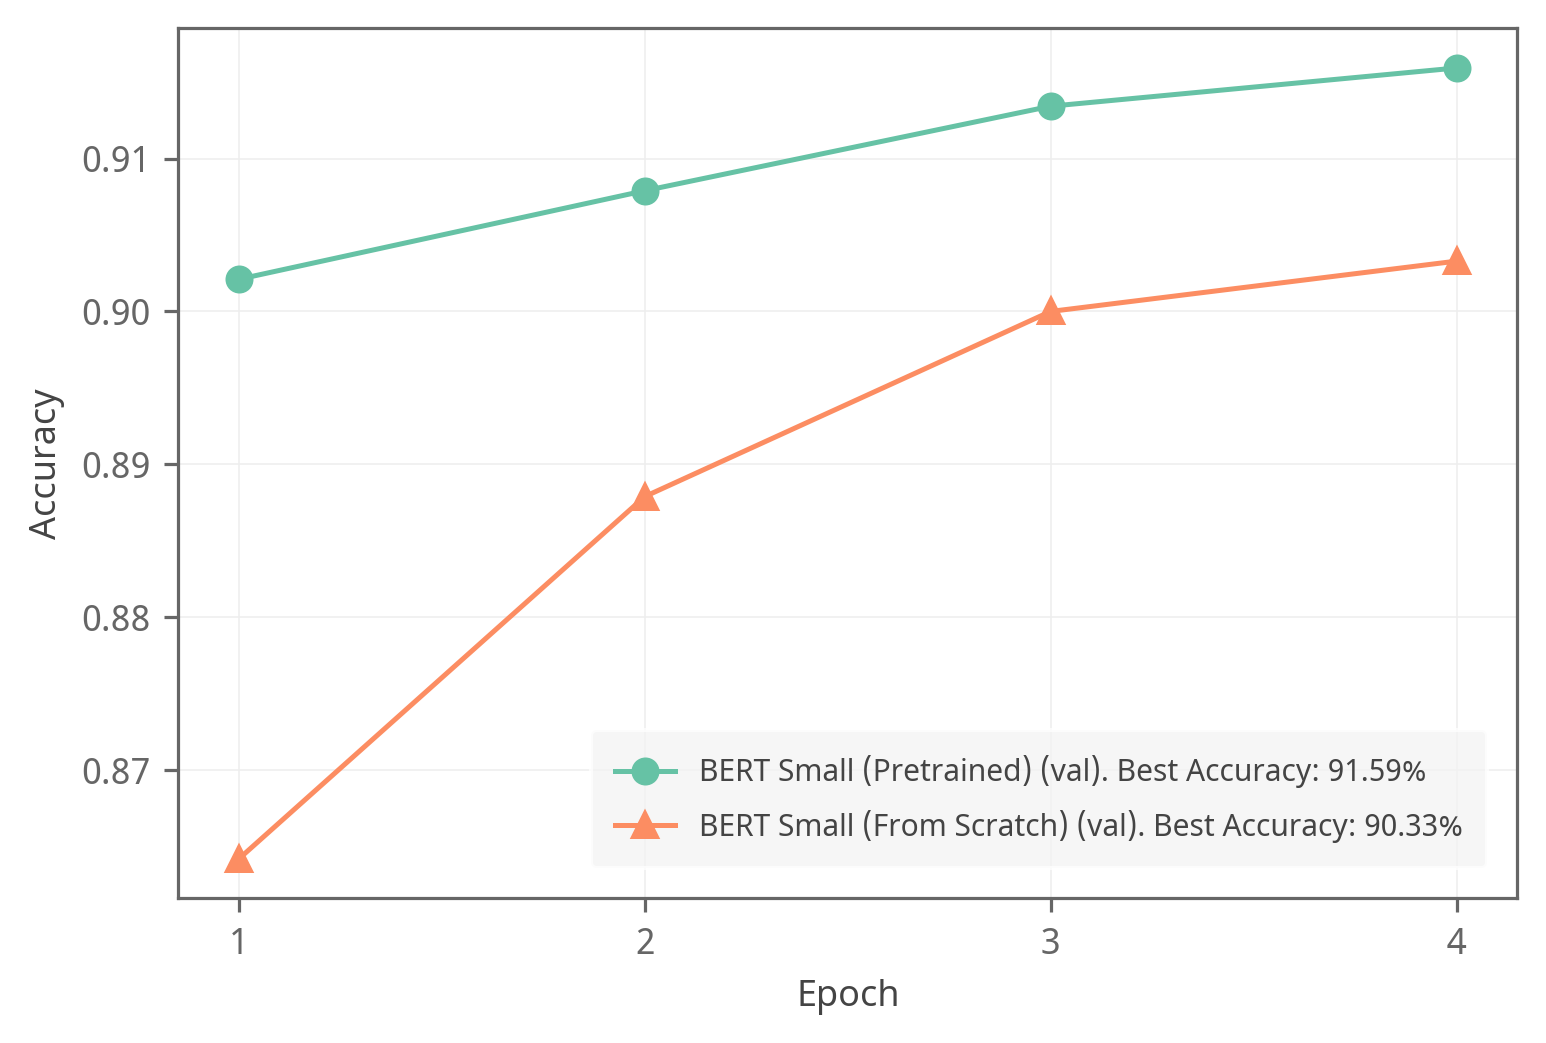

In [62]:
plot_training_trajectories(
    [
        bert_small_pretrained_classifier_history,
        bert_small_from_scratch_classifier_history, 
    ], 
    ['BERT Small (Pretrained)', 'BERT Small (From Scratch)']
)

As is clear, the BERT Small model with the pretrained weights clearly outperforms the model which is trained from scratch.

## Larger BERT models.

In [66]:
bert_base_from_scratch_classifier = get_bert_model(
    'bert-base', learning_rate=2e-5, keep_tfhub_weights=False)
bert_base_from_scratch_classifier_history = bert_base_from_scratch_classifier.fit(
    x=train_ds, epochs=4, validation_data=test_ds)

Epoch 1/4
469/469 [==============================] - 232s 319ms/step - loss: 0.7738 - accuracy: 0.6602 - val_loss: 0.4527 - val_accuracy: 0.8455
Epoch 2/4
469/469 [==============================] - 91s 194ms/step - loss: 0.3712 - accuracy: 0.8713 - val_loss: 0.3440 - val_accuracy: 0.8897
Epoch 3/4
469/469 [==============================] - 91s 194ms/step - loss: 0.2980 - accuracy: 0.8982 - val_loss: 0.3303 - val_accuracy: 0.8975
Epoch 4/4
469/469 [==============================] - 95s 201ms/step - loss: 0.2553 - accuracy: 0.9126 - val_loss: 0.3346 - val_accuracy: 0.9007


In [60]:
bert_base_pretrained_classifier = get_bert_model(
    'bert-base', learning_rate=8e-5, keep_tfhub_weights=True)
bert_base_pretrained_classifier_history = bert_base_pretrained_classifier.fit(
    x=train_ds, epochs=4, validation_data=test_ds)

Epoch 1/4
469/469 [==============================] - 233s 316ms/step - loss: 0.2441 - accuracy: 0.9176 - val_loss: 0.1814 - val_accuracy: 0.9382
Epoch 2/4
469/469 [==============================] - 91s 193ms/step - loss: 0.1415 - accuracy: 0.9522 - val_loss: 0.1894 - val_accuracy: 0.9380
Epoch 3/4
469/469 [==============================] - 91s 194ms/step - loss: 0.0975 - accuracy: 0.9668 - val_loss: 0.2023 - val_accuracy: 0.9397
Epoch 4/4
469/469 [==============================] - 91s 195ms/step - loss: 0.0677 - accuracy: 0.9773 - val_loss: 0.2233 - val_accuracy: 0.9336


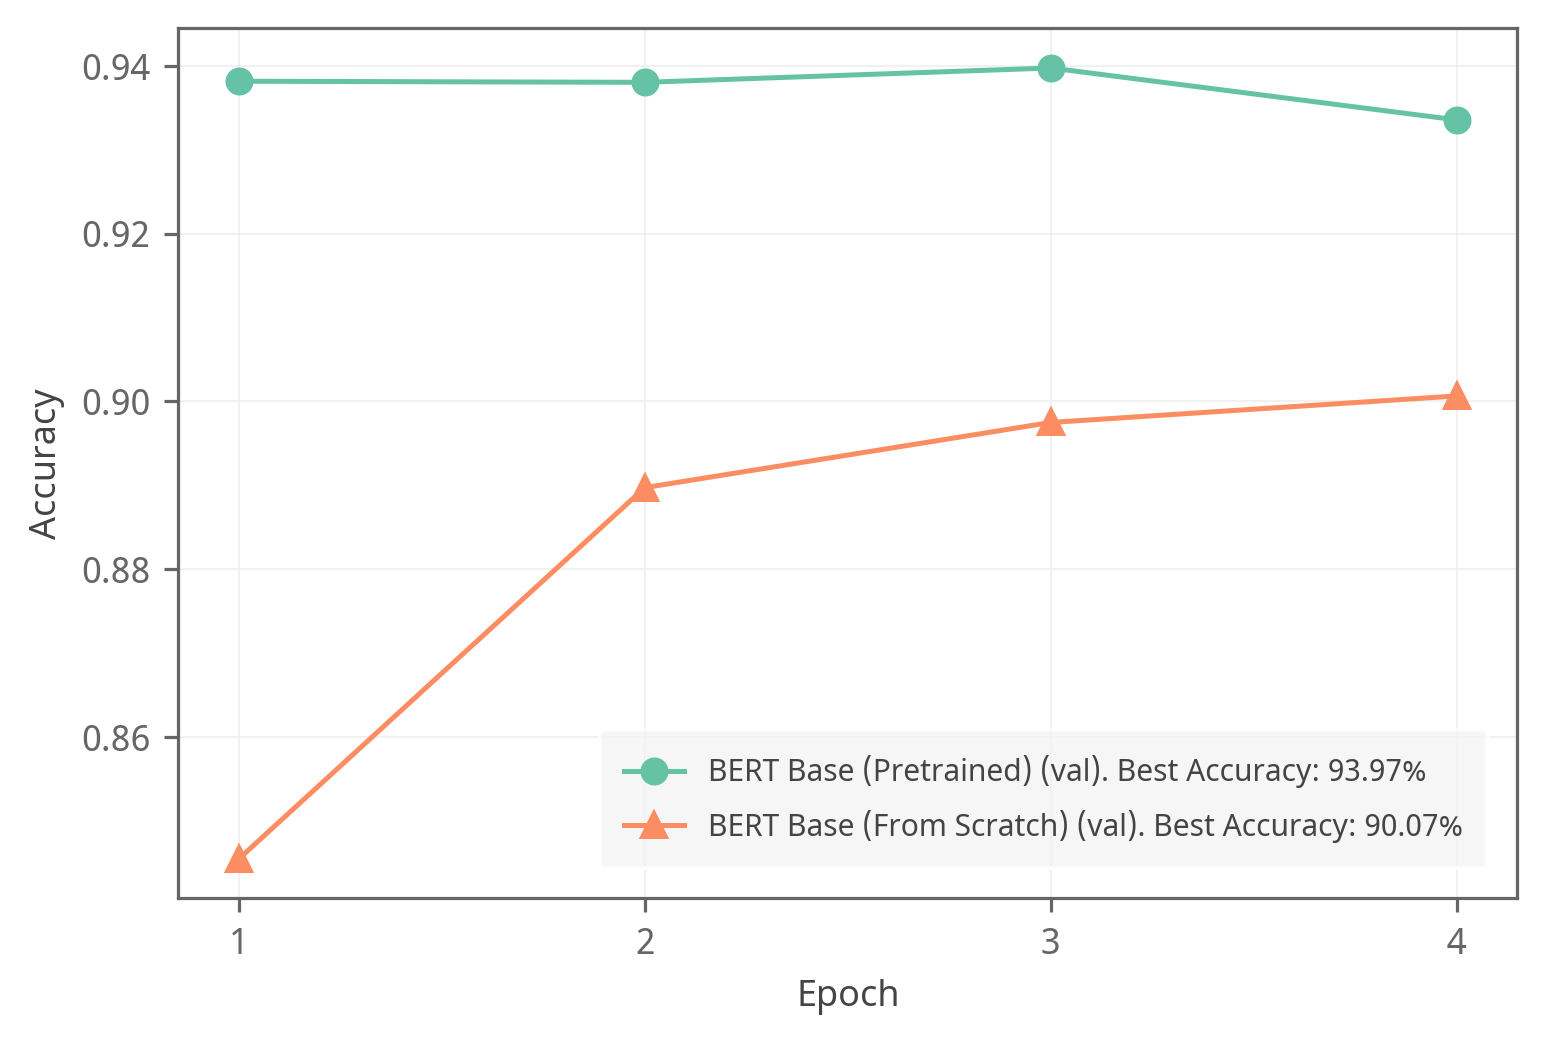

In [67]:
plot_training_trajectories(
    [
        bert_base_pretrained_classifier_history,
        bert_base_from_scratch_classifier_history, 
    ], 
    ['BERT Base (Pretrained)', 'BERT Base (From Scratch)']
)

In [ ]:
bert_base_classifier = get_bert_model('bert-base', True, keep_weights=True)
bert_base_classifier.fit(x=train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
469/469 [==============================] - 234s 317ms/step - loss: 0.3094 - accuracy: 0.8954 - val_loss: 0.2027 - val_accuracy: 0.9309
Epoch 2/5
469/469 [==============================] - 90s 192ms/step - loss: 0.1694 - accuracy: 0.9429 - val_loss: 0.1918 - val_accuracy: 0.9337
Epoch 3/5
469/469 [==============================] - 91s 193ms/step - loss: 0.1306 - accuracy: 0.9564 - val_loss: 0.1913 - val_accuracy: 0.9361
Epoch 4/5
469/469 [==============================] - 90s 192ms/step - loss: 0.1008 - accuracy: 0.9664 - val_loss: 0.1937 - val_accuracy: 0.9380
Epoch 5/5
469/469 [==============================] - 90s 192ms/step - loss: 0.0779 - accuracy: 0.9740 - val_loss: 0.2072 - val_accuracy: 0.9378


We see a similar behavior for BERT base as well, where pre-training helps achieve a significant boost as compared to training from scratch.